# Pix2Pix (Image-to-Image Translation with Conditional Adversarial Networks)

### 本章節內容大綱
* [Build a Pix2Pix Model](#Build-a-Pix2Pix-Model)
* [Build a UNET model as Generator](#Build-a-UNET-model-as-Generator)
* [Build a PatchGAN as Discriminator](#Build-a-PatchGAN-as-Discriminator)
* [Loss function](#Loss-function)

<br>
<img src="https://hackmd.io/_uploads/BJbwlIWl6.jpg" width=700  />

Pix2Pix是CGAN(conditional GAN)的一種，與vanilla gan不同的是，其input為一張圖片，而output出我們想要變成的樣子(不像是vanilla GAN無法控制想要output的樣子)，像是上面的例子：把標記的segmentation變成圖片、把黑白照片轉成彩色照片等等，資料上需要一個個的pair data(labels與圖片)，是supervised learning的一種。

# Import

In [1]:
''' basic package '''
import os
import time
import glob
from IPython.display import display, Image, clear_output

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv2DTranspose, Conv2D, BatchNormalization,
    LeakyReLU, Dropout, Reshape, Flatten
)

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
# 下載 facades dataset 到 hub 裡面的 home/jovyan/.keras 資料夾
_URL = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30179328/30168306 [==============================] - 51s 2us/step


# Config

In [4]:
BUFFER_SIZE = 400  # total 400 張圖片
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

2023-09-27 11:36:33.110534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 11:36:33.768780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


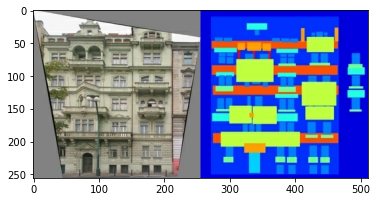

In [5]:
# plot 原始圖片
image = tf.io.read_file(PATH+'train/100.jpg')
# 將 image decode 為 unit8 的 tensor
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [6]:
def load(image_file):
    image = tf.io.read_file(image_file)
    # 將 image decode 為 unit8 的 tensor
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    # 因為原始圖片是將 image 與 label 黏在一起，所以這邊要把他們切開
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    # 將 image datatype 改為 float32
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

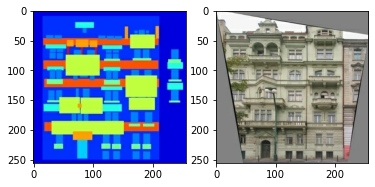

In [7]:
inp, re = load(PATH+'train/100.jpg')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(inp/255.0)
axs[1].imshow(re/255.0)

In [8]:
def resize(input_image, real_image, height, width):
    # 將圖片放大成我們想要的大小，方法是用 NEAREST_NEIGHBOR 最鄰近插值法
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    # 將圖片一張一張疊起來(類似append)
    stacked_image = tf.stack([input_image, real_image], axis=0)
    # 將圖片隨機切割成我們想要的大小： 256 x 256
    # 我們不想要隨機切 stack_size 與 channel 的部分，故就輸入其原始的 shape: stack_size=2 和 channel=3
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


# 將圖片正規化到 -1 到 1 之間
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [9]:
@tf.function()
# data augmentation
def random_jitter(input_image, real_image):
    # 調整圖片大小至 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # 隨機切割圖片至 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    # 隨機水平翻轉圖片
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

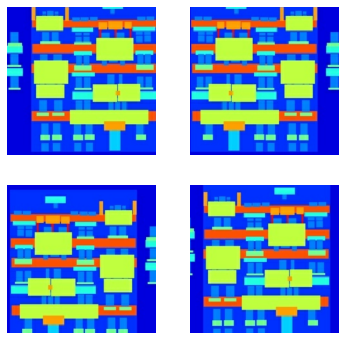

In [10]:
# 檢查 jitter 後的結果
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [11]:
# 定義 train/test generator
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


# no jitter at testing!
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
# num_parallel_calls 是一次準備多少圖片一起處理，他可以最佳化到底要讀多少圖的這個參數
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
OUTPUT_CHANNELS = 3

# Build a Pix2Pix Model

<br>
<img src="https://hackmd.io/_uploads/HkrYxLWx6.png" width=700  />

Pix2Pix的Generator因為是要將標籤圖片(labels)轉為照片，所以整個模型要使用類似Autoencoder的結構，稱作Unet，其實Unet與Autoencoder的結構基本上一樣，只是增加了skip connection來增加圖像的品質。
而Discriminator則與之前差不多，目的是要透過真實的data作為依據，判斷餵進來的圖是真的還是假的。

這邊先將 Generator 與 Discriminator 需要用到的結構：Downsample與Upsample寫成 function 備用。

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)  # mean=0, stddev=0.02

    result = tf.keras.Sequential()

    # 因為預設會使用 batchnorm，所以不需要加 bias
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    # 還記得 Vanilla GAN 裡提到的 Conv2DTranspose 的介紹嗎？忘記了可以再回去看喔！
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

## Build a UNET model as Generator

Unet的結構如前述所說，就是一個有skip connection的Autoencoder，

In [16]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # 最後 output 的 range 要在 -1 ~ 1 之間，所以選用的 activation function 是 "tanh"
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

    # Downsampling
    # 用一個 list 將每層的輸出存起來，之後再 Upsampling 時可以使用
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])  # 把 skip connections 的值存起來並顛倒，後面在 upsampling 時會用到

    # Upsampling 和 skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

2023-09-27 11:36:36.212999: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


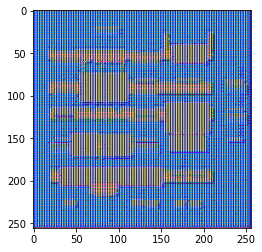

In [17]:
generator = Generator()

# 測試 output 是不是跟我們想要的一樣
# 記得training要設成 false 否則 batchnorm 裡面的參數會被更新
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Build a PatchGAN as Discriminator

Discriminator相對單純，比較不一樣的地方是這邊所使用的是Markovian discriminator(PatchGAN)，簡單來說就是在最後的輸出不要將feature maps轉成一個值作分類，而是把圖切成NxN的Patch一格格作判斷，之後取平均的概念。

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar], axis=-1)  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

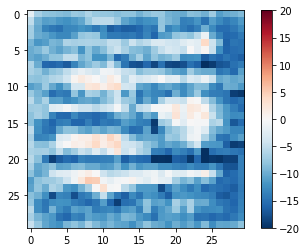

In [19]:
# 畫出 discriminator 的 output，確認是我們要的樣子
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# Loss function

這邊的discriminator與一般的一樣，而Generator有些微的差異，即加入了identity loss來修正output與實際圖片的差異。

- Discriminator loss
    - real_loss: 更新將真實資料判斷成生成資料的狀況
    - generated_loss: 更新將生成資料判斷成真實資料的狀況
    
- Generator loss
    - gan_loss: 更新生成資料被Discriminator判斷成生成資料的狀況
    - l1_loss: 修正生成資料與對應該label image的真實資料實際的差異（identity loss）

In [20]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # 加入 L1 loss 來增加模型的 robustness 與細緻度， 影像也較 L2 loss 不模糊
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 200


def generate_images(model, test_input, tar):

    prediction = model(test_input, training=True)  # 這邊設 training=True 是希望能得到 test_input 的一些統計量
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # 將圖片像素值調整至 0 - 1 之間才能 plot
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))


def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        # Train
        for input_image, target in train_ds:
            train_step(input_image, target)

        # 每 10 個 epochs 顯示一次圖片
        if (epoch + 1) % 10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)

        # 每 50 個 epochs 存一次 weight
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                           time.time()-start))

Time taken for epoch 1 is 27.050973176956177 sec

Time taken for epoch 2 is 24.451849937438965 sec

Time taken for epoch 3 is 24.46899914741516 sec

Time taken for epoch 4 is 24.506251573562622 sec

Time taken for epoch 5 is 24.56710386276245 sec

Time taken for epoch 6 is 24.59904384613037 sec

Time taken for epoch 7 is 24.60086989402771 sec

Time taken for epoch 8 is 24.609594583511353 sec

Time taken for epoch 9 is 24.63762617111206 sec



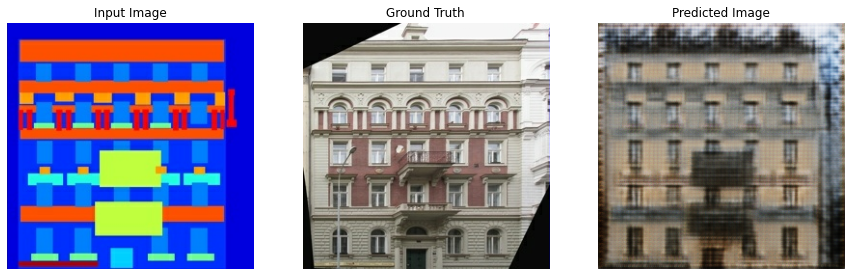

Time taken for epoch 10 is 24.970795392990112 sec

Time taken for epoch 11 is 24.699246406555176 sec

Time taken for epoch 12 is 24.728347063064575 sec

Time taken for epoch 13 is 24.786288738250732 sec

Time taken for epoch 14 is 24.73538064956665 sec

Time taken for epoch 15 is 24.751777410507202 sec

Time taken for epoch 16 is 24.737823247909546 sec

Time taken for epoch 17 is 24.741528511047363 sec

Time taken for epoch 18 is 24.74972653388977 sec

Time taken for epoch 19 is 24.760743141174316 sec



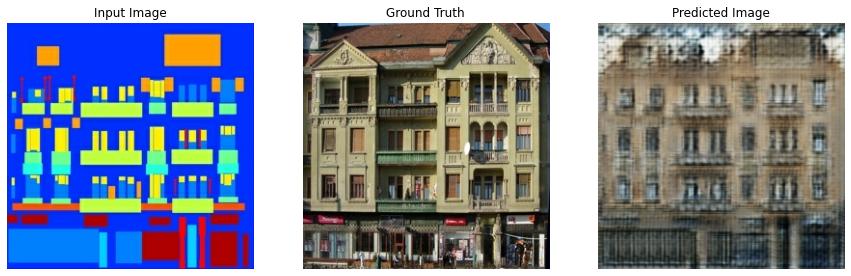

Time taken for epoch 20 is 25.04367756843567 sec

Time taken for epoch 21 is 24.733442068099976 sec

Time taken for epoch 22 is 24.777700424194336 sec

Time taken for epoch 23 is 24.811139583587646 sec

Time taken for epoch 24 is 24.854506492614746 sec

Time taken for epoch 25 is 24.750758171081543 sec

Time taken for epoch 26 is 24.72981858253479 sec

Time taken for epoch 27 is 24.760510683059692 sec

Time taken for epoch 28 is 24.765018939971924 sec

Time taken for epoch 29 is 24.756272077560425 sec



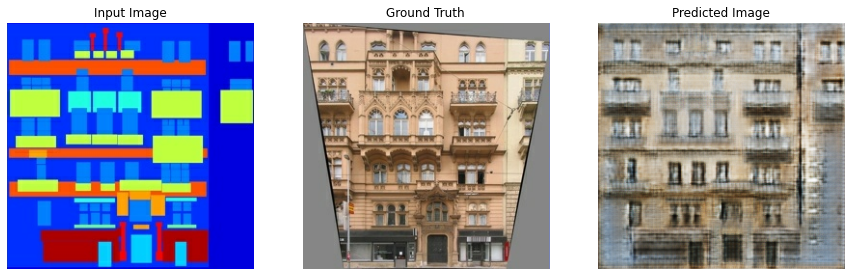

Time taken for epoch 30 is 25.038817644119263 sec

Time taken for epoch 31 is 24.82059335708618 sec

Time taken for epoch 32 is 24.73485803604126 sec

Time taken for epoch 33 is 24.793596029281616 sec

Time taken for epoch 34 is 24.795841693878174 sec

Time taken for epoch 35 is 24.825947999954224 sec

Time taken for epoch 36 is 24.83655333518982 sec

Time taken for epoch 37 is 24.864197969436646 sec

Time taken for epoch 38 is 24.75448751449585 sec

Time taken for epoch 39 is 24.745985507965088 sec



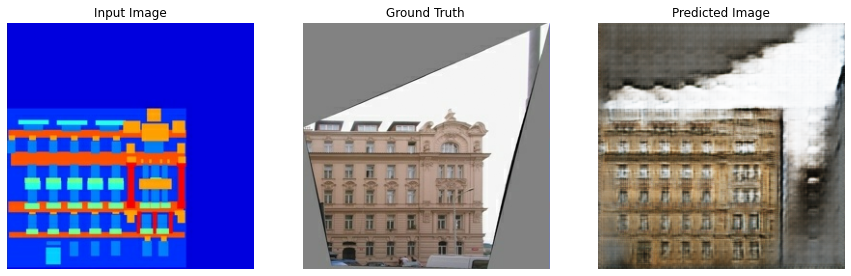

Time taken for epoch 40 is 25.18443465232849 sec

Time taken for epoch 41 is 24.732222080230713 sec

Time taken for epoch 42 is 24.76341676712036 sec

Time taken for epoch 43 is 24.752780199050903 sec

Time taken for epoch 44 is 24.73966956138611 sec

Time taken for epoch 45 is 24.76140594482422 sec

Time taken for epoch 46 is 24.721983909606934 sec

Time taken for epoch 47 is 24.743433713912964 sec

Time taken for epoch 48 is 24.731279611587524 sec

Time taken for epoch 49 is 24.763330936431885 sec



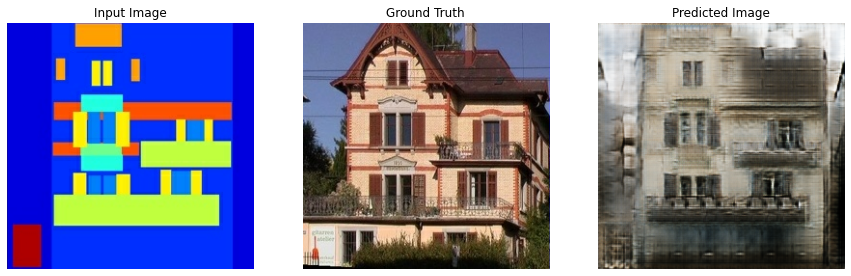

Time taken for epoch 50 is 34.98964500427246 sec

Time taken for epoch 51 is 24.603556394577026 sec

Time taken for epoch 52 is 24.605279445648193 sec

Time taken for epoch 53 is 24.71406626701355 sec

Time taken for epoch 54 is 24.7419536113739 sec

Time taken for epoch 55 is 24.767518281936646 sec

Time taken for epoch 56 is 24.745378255844116 sec

Time taken for epoch 57 is 24.75580382347107 sec

Time taken for epoch 58 is 24.757827520370483 sec

Time taken for epoch 59 is 24.78871178627014 sec



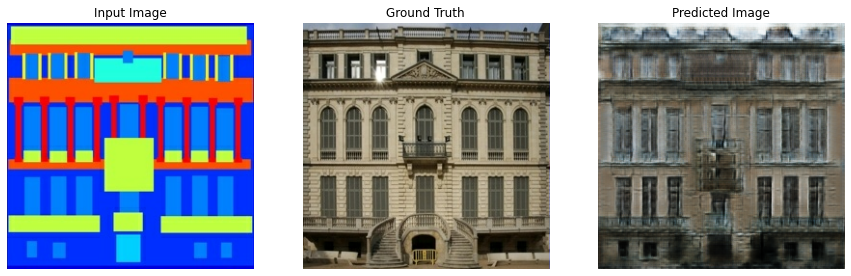

Time taken for epoch 60 is 25.014063596725464 sec

Time taken for epoch 61 is 24.737733602523804 sec

Time taken for epoch 62 is 24.781561136245728 sec

Time taken for epoch 63 is 24.75462293624878 sec

Time taken for epoch 64 is 24.743244171142578 sec

Time taken for epoch 65 is 24.761358737945557 sec

Time taken for epoch 66 is 24.781920433044434 sec

Time taken for epoch 67 is 24.744247436523438 sec

Time taken for epoch 68 is 24.742708444595337 sec

Time taken for epoch 69 is 24.717782020568848 sec



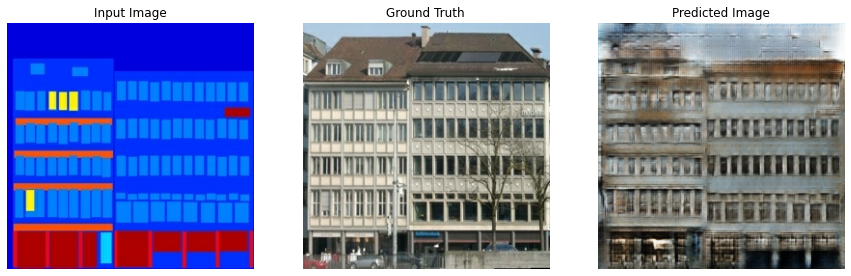

Time taken for epoch 70 is 25.024950981140137 sec

Time taken for epoch 71 is 24.740742206573486 sec

Time taken for epoch 72 is 24.753518104553223 sec

Time taken for epoch 73 is 24.737585306167603 sec

Time taken for epoch 74 is 24.768422603607178 sec

Time taken for epoch 75 is 24.733487129211426 sec

Time taken for epoch 76 is 24.733239889144897 sec

Time taken for epoch 77 is 24.734264850616455 sec

Time taken for epoch 78 is 24.75211191177368 sec

Time taken for epoch 79 is 24.709787607192993 sec



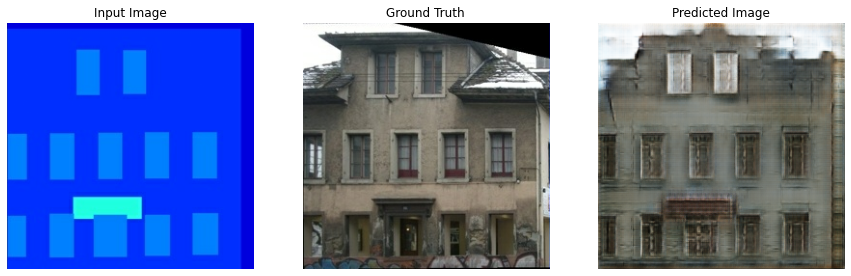

Time taken for epoch 80 is 24.994999885559082 sec

Time taken for epoch 81 is 24.756714820861816 sec

Time taken for epoch 82 is 24.73514699935913 sec

Time taken for epoch 83 is 24.7066433429718 sec

Time taken for epoch 84 is 24.745255947113037 sec

Time taken for epoch 85 is 24.74094009399414 sec

Time taken for epoch 86 is 24.741512298583984 sec

Time taken for epoch 87 is 24.72813105583191 sec

Time taken for epoch 88 is 24.75344467163086 sec

Time taken for epoch 89 is 24.726483583450317 sec



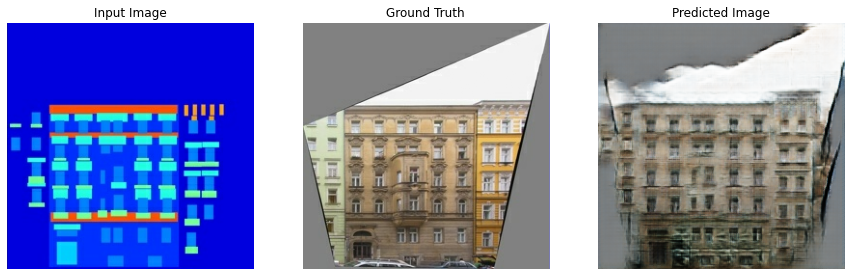

Time taken for epoch 90 is 25.01759386062622 sec

Time taken for epoch 91 is 24.719197273254395 sec

Time taken for epoch 92 is 24.739949226379395 sec

Time taken for epoch 93 is 24.721728086471558 sec

Time taken for epoch 94 is 24.715982675552368 sec

Time taken for epoch 95 is 24.71126437187195 sec

Time taken for epoch 96 is 24.74479341506958 sec

Time taken for epoch 97 is 24.7110698223114 sec

Time taken for epoch 98 is 24.68168568611145 sec

Time taken for epoch 99 is 24.72243571281433 sec



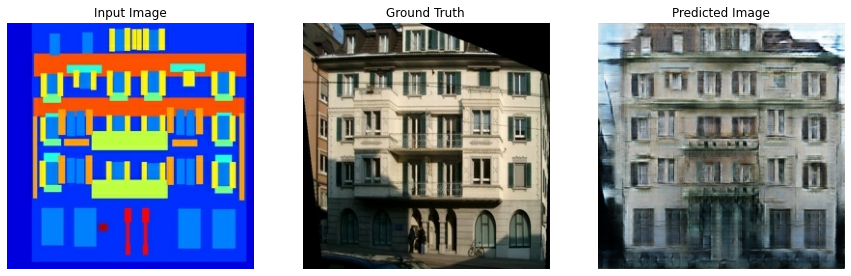

Time taken for epoch 100 is 34.333632946014404 sec

Time taken for epoch 101 is 24.637351989746094 sec

Time taken for epoch 102 is 24.61477017402649 sec

Time taken for epoch 103 is 24.70230221748352 sec

Time taken for epoch 104 is 24.737223386764526 sec

Time taken for epoch 105 is 24.74867820739746 sec

Time taken for epoch 106 is 24.76010251045227 sec

Time taken for epoch 107 is 24.750486612319946 sec

Time taken for epoch 108 is 24.72475576400757 sec

Time taken for epoch 109 is 24.72317337989807 sec



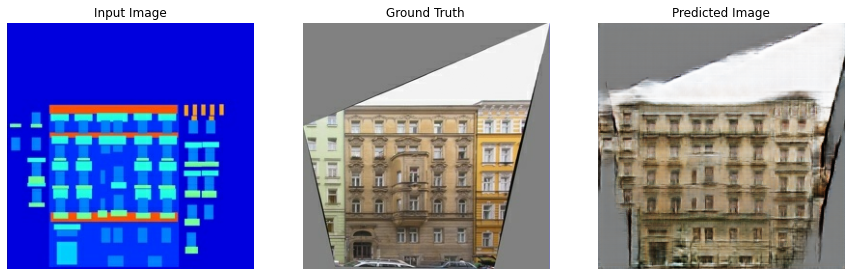

Time taken for epoch 110 is 25.21009087562561 sec

Time taken for epoch 111 is 24.706997871398926 sec

Time taken for epoch 112 is 24.740106105804443 sec

Time taken for epoch 113 is 24.733539819717407 sec

Time taken for epoch 114 is 24.767338514328003 sec

Time taken for epoch 115 is 24.755919456481934 sec

Time taken for epoch 116 is 24.773919343948364 sec

Time taken for epoch 117 is 24.75336265563965 sec

Time taken for epoch 118 is 24.740970849990845 sec

Time taken for epoch 119 is 24.751601934432983 sec



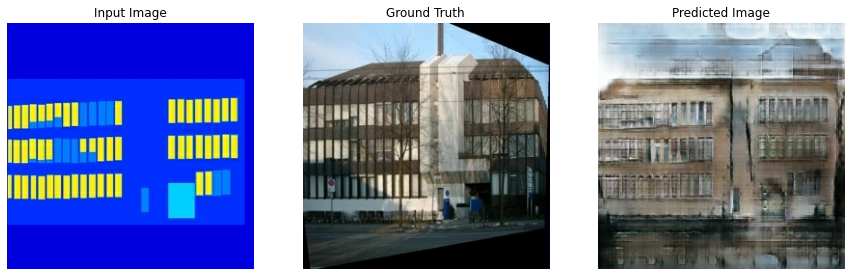

Time taken for epoch 120 is 25.031652450561523 sec

Time taken for epoch 121 is 24.772506713867188 sec

Time taken for epoch 122 is 24.812368392944336 sec

Time taken for epoch 123 is 24.778056383132935 sec

Time taken for epoch 124 is 24.75506091117859 sec

Time taken for epoch 125 is 24.752931356430054 sec

Time taken for epoch 126 is 24.751575469970703 sec

Time taken for epoch 127 is 24.73856544494629 sec

Time taken for epoch 128 is 24.74178719520569 sec

Time taken for epoch 129 is 24.761643171310425 sec



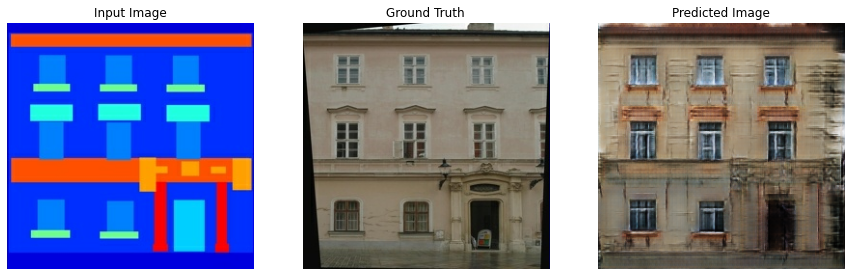

Time taken for epoch 130 is 25.031506538391113 sec

Time taken for epoch 131 is 24.756532430648804 sec

Time taken for epoch 132 is 24.768614530563354 sec

Time taken for epoch 133 is 24.74601721763611 sec

Time taken for epoch 134 is 24.742963552474976 sec

Time taken for epoch 135 is 24.77672576904297 sec

Time taken for epoch 136 is 24.742608547210693 sec

Time taken for epoch 137 is 24.756325006484985 sec

Time taken for epoch 138 is 24.73401165008545 sec

Time taken for epoch 139 is 24.715728759765625 sec



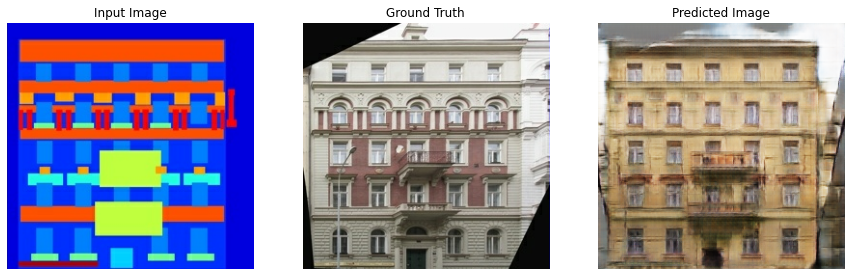

Time taken for epoch 140 is 25.06111192703247 sec

Time taken for epoch 141 is 24.770181894302368 sec

Time taken for epoch 142 is 24.76473617553711 sec

Time taken for epoch 143 is 24.79536533355713 sec

Time taken for epoch 144 is 24.763224124908447 sec

Time taken for epoch 145 is 24.779111862182617 sec

Time taken for epoch 146 is 24.75344944000244 sec

Time taken for epoch 147 is 24.762614965438843 sec

Time taken for epoch 148 is 24.766301155090332 sec

Time taken for epoch 149 is 24.762065410614014 sec



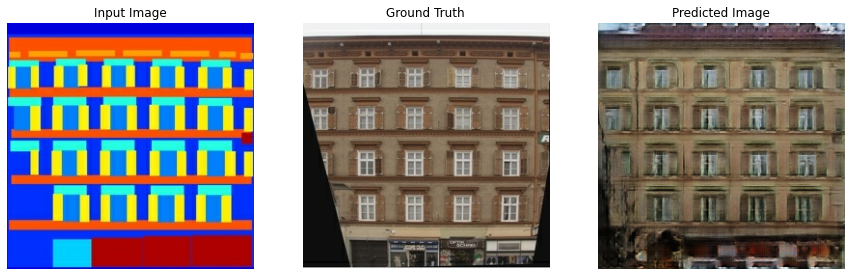

Time taken for epoch 150 is 34.01973032951355 sec

Time taken for epoch 151 is 24.57824468612671 sec

Time taken for epoch 152 is 24.596068143844604 sec

Time taken for epoch 153 is 24.68635129928589 sec

Time taken for epoch 154 is 24.78015446662903 sec

Time taken for epoch 155 is 24.768909454345703 sec

Time taken for epoch 156 is 24.745075225830078 sec

Time taken for epoch 157 is 24.735471487045288 sec

Time taken for epoch 158 is 24.73475933074951 sec

Time taken for epoch 159 is 24.732189178466797 sec



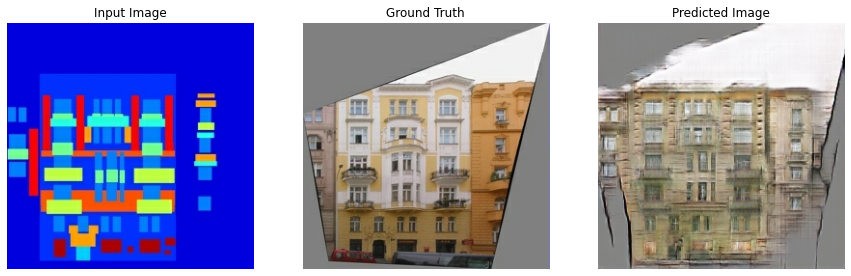

Time taken for epoch 160 is 25.017296314239502 sec

Time taken for epoch 161 is 24.73473024368286 sec

Time taken for epoch 162 is 24.721616744995117 sec

Time taken for epoch 163 is 24.747502326965332 sec

Time taken for epoch 164 is 24.737567901611328 sec

Time taken for epoch 165 is 24.729904174804688 sec

Time taken for epoch 166 is 24.730786085128784 sec

Time taken for epoch 167 is 24.709089994430542 sec

Time taken for epoch 168 is 24.7340407371521 sec

Time taken for epoch 169 is 24.756505250930786 sec



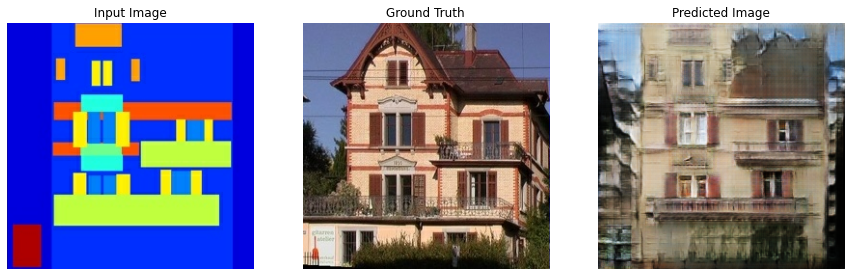

Time taken for epoch 170 is 24.99413013458252 sec

Time taken for epoch 171 is 24.745502948760986 sec

Time taken for epoch 172 is 24.759117126464844 sec

Time taken for epoch 173 is 24.76165533065796 sec

Time taken for epoch 174 is 24.742502450942993 sec

Time taken for epoch 175 is 24.749877452850342 sec

Time taken for epoch 176 is 24.736743927001953 sec

Time taken for epoch 177 is 24.729061365127563 sec

Time taken for epoch 178 is 24.755961894989014 sec

Time taken for epoch 179 is 24.763105869293213 sec



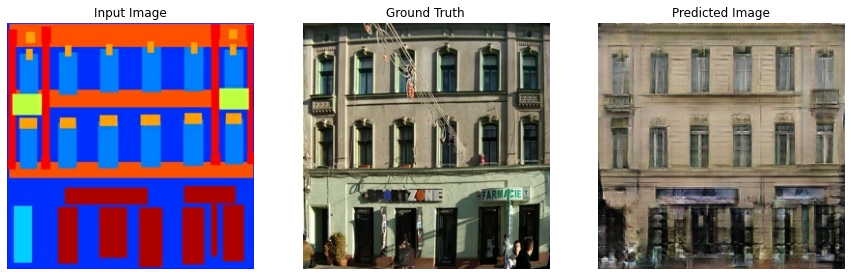

Time taken for epoch 180 is 25.00258779525757 sec

Time taken for epoch 181 is 24.720852375030518 sec

Time taken for epoch 182 is 24.731202602386475 sec

Time taken for epoch 183 is 24.723482131958008 sec

Time taken for epoch 184 is 24.748685121536255 sec

Time taken for epoch 185 is 24.740938901901245 sec

Time taken for epoch 186 is 24.727564096450806 sec

Time taken for epoch 187 is 24.74118185043335 sec

Time taken for epoch 188 is 24.725728511810303 sec

Time taken for epoch 189 is 24.73346447944641 sec



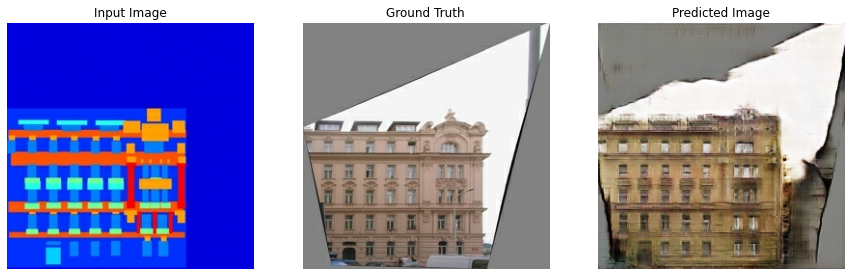

Time taken for epoch 190 is 24.99228596687317 sec

Time taken for epoch 191 is 24.77028250694275 sec

Time taken for epoch 192 is 24.75644588470459 sec

Time taken for epoch 193 is 24.742634773254395 sec

Time taken for epoch 194 is 24.77522611618042 sec

Time taken for epoch 195 is 24.74983310699463 sec

Time taken for epoch 196 is 24.74343729019165 sec

Time taken for epoch 197 is 24.73953342437744 sec

Time taken for epoch 198 is 24.76321291923523 sec

Time taken for epoch 199 is 24.771499633789062 sec



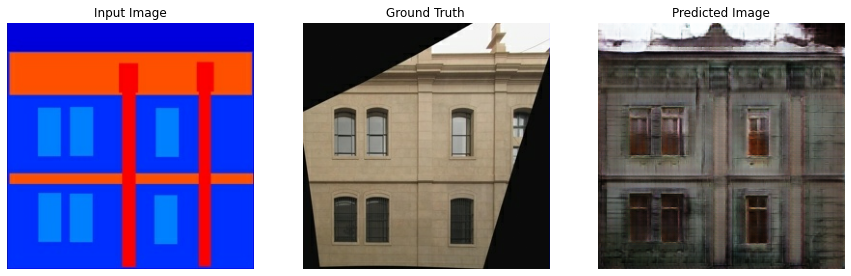

Time taken for epoch 200 is 33.83317804336548 sec



In [23]:
fit(train_dataset, EPOCHS, test_dataset)

最後將存好的weight載入，試試看生成一些圖片吧！

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

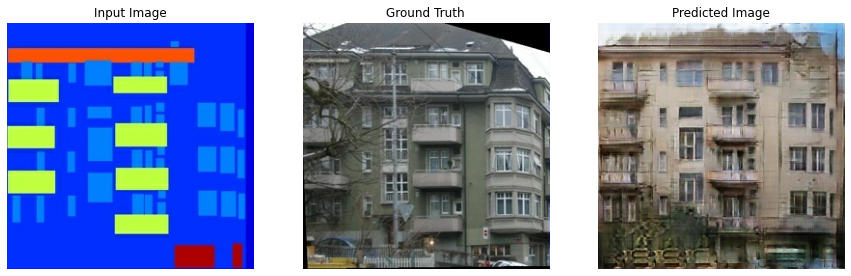

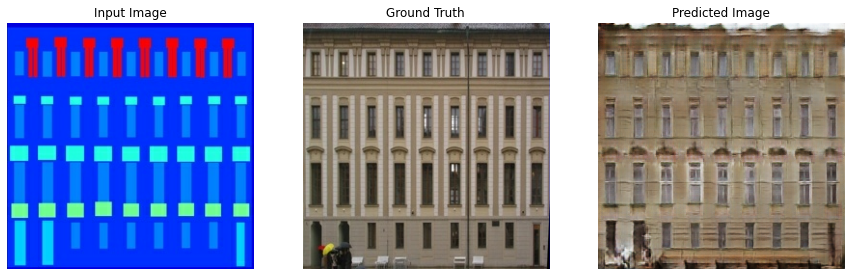

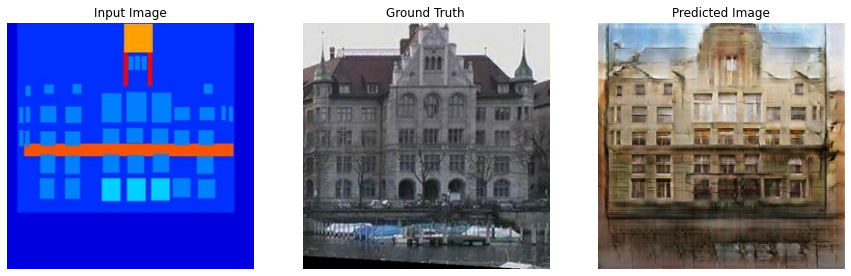

In [ ]:
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)